<h1 align="center">Toy Example</h1>

## Method for generating toy examples

We are going to generate $M=12000$ random samples represented original information
which each sample is $9$ dimensions.
Then, extract two single view sample with $12$ dimensions from each original sample.

### 1. Original samples matrix

Firstly, generate original samples randomly as below.

$$V \sim \Gamma(1,0.9) + N(0,0.1)+0.5, V \in R^{M \times 9}$$

Then, set some positions of each sample as $0$ to split to multiple categories.Let's think of $i$ as a feature (non-zero number).

+ Sample of category 0 format to be $[i,i,i,0,0,0,0,0,0]$.
+ Sample of category 1 format to be $[0,0,0,i,i,i,0,0,0]$.
+ Sample of category 2 format to be $[0,0,0,i,i,i,i,i,i]$.

### 2. Transformational matrix of 2 views

Two matrix $U_1$ and $U_2$ sampled randomly distributed $U(0.4,1)$.
And, set some row to be $0$ by following way.

$$U_1=U(0.4,1)\odot\begin{bmatrix}1&0&1&1&0&1&0&0&0\\\vdots&\vdots&\vdots&\vdots&\vdots&\vdots&\vdots&\vdots&\vdots \end{bmatrix}^T, U_1 \in R^{9\times 12}$$
$$U_2=U(0.4,1)\odot\begin{bmatrix}0&1&1&0&1&1&1&1&1\\\vdots&\vdots&\vdots&\vdots&\vdots&\vdots&\vdots&\vdots&\vdots \end{bmatrix}^T, U_2 \in R^{9\times 12}$$

In addition, set 30% elements of $U_1$ and $U_2$ to be $0$.

### 3. Generate final samples

Finally, two broken views generated:

$$X_1=V U_1 + N(0,0.1), X_1 \in R^{M\times 12}$$

$$X_2=V U_2 + N(0,0.8), X_2 \in R^{M\times 12}$$


In [4]:
def generate_toy_example(M=12000):
    import pickle
    import numpy as np
    # 1.1 Generate original samples V.
    V = np.random.gamma(1, 0.9, size=(M, 9)) + np.random.normal(0, 0.1, size=(M, 9)) + 0.5

    # 1.2 Set some positions as 0.
    V[:4000, 3:] = 0      # Category 0 has features on dimension 0,1 and 2.
    V[4000:8000, :3] = 0  # Category 1 has features on dimension 3,4 and 5.
    V[4000:8000, 6:] = 0
    V[8000:, :3] = 0      # Category 2 has features on dimension 3,4, 5,6,7,8.

    # 1.3 Generate labels.
    labels = np.empty(M, dtype=np.int64)
    labels[:4000] = 0
    labels[4000:8000] = 1
    labels[8000:] = 2

    # 1.4 Reorder samples randomly.
    rand_indices = np.random.permutation(len(V))
    V = V[rand_indices]
    labels = labels[rand_indices]

    # 2.1 Generate U_1 and U_2
    U1 = np.random.uniform(0.4, 1.0, size=(9, 12))
    U1[[1, 4, 6, 7, 8]] = 0
    U2 = np.random.uniform(0.4, 1.0, size=(9, 12))
    U2[[0, 3]] = 0

    # 2.2 Set 30% elements of U1 and U2 to be 0.
    U1 = U1 * (np.random.randint(1, 100, size=(9, 12)) > 30)
    U2 = U2 * (np.random.randint(1, 100, size=(9, 12)) > 30)

    # 3. Get X_1 and X_2
    X1 = V @ U1 + np.random.normal(0, 0.1, size=(M, 12))
    X2 = V @ U2 + np.random.normal(0, 0.8, size=(M, 12))

    # 4. Save dataset
    pickle.dump([{0: X1, 1: X2}, labels], open('ToyExample_2views.pkl', 'wb'))
    # pickle.dump([V, labels], open('ToyExample_origin.pkl', 'wb'))


generate_toy_example()

## Visualization

### 1. Load data and reduce the dimension by t-sne

In [ ]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset


class MultiViewToyExample(Dataset):

    def __init__(self, path='ToyExample_2views.pkl', train=None, train_rate=0.8):
        self.x, self.y = pickle.load(open(path, 'rb'))
        self.x = {k: MinMaxScaler().fit_transform(v).astype(np.float32) for k, v in self.x.items()}
        if train is not None:
            train_size = int(len(self.y) * train_rate)
            if train:
                self.x = {k: v[:train_size] for k, v in self.x.items()}
                self.y = np.array(self.y[:train_size], dtype=np.long)
            else:
                self.x = {k: v[train_size:] for k, v in self.x.items()}
                self.y = np.array(self.y[train_size:], dtype=np.long)

    def __getitem__(self, index):
        x = {k: v[index] for k, v in self.x.items()}
        return index, x, self.y[index]

    def __len__(self):
        return len(self.y)


data_toy = MultiViewToyExample()
t_sne = TSNE(n_components=2)
features = {k: t_sne.fit_transform(v[:3000]) for k, v in data_toy.x.items()}
labels = data_toy.y[:3000]

### 2. Plot

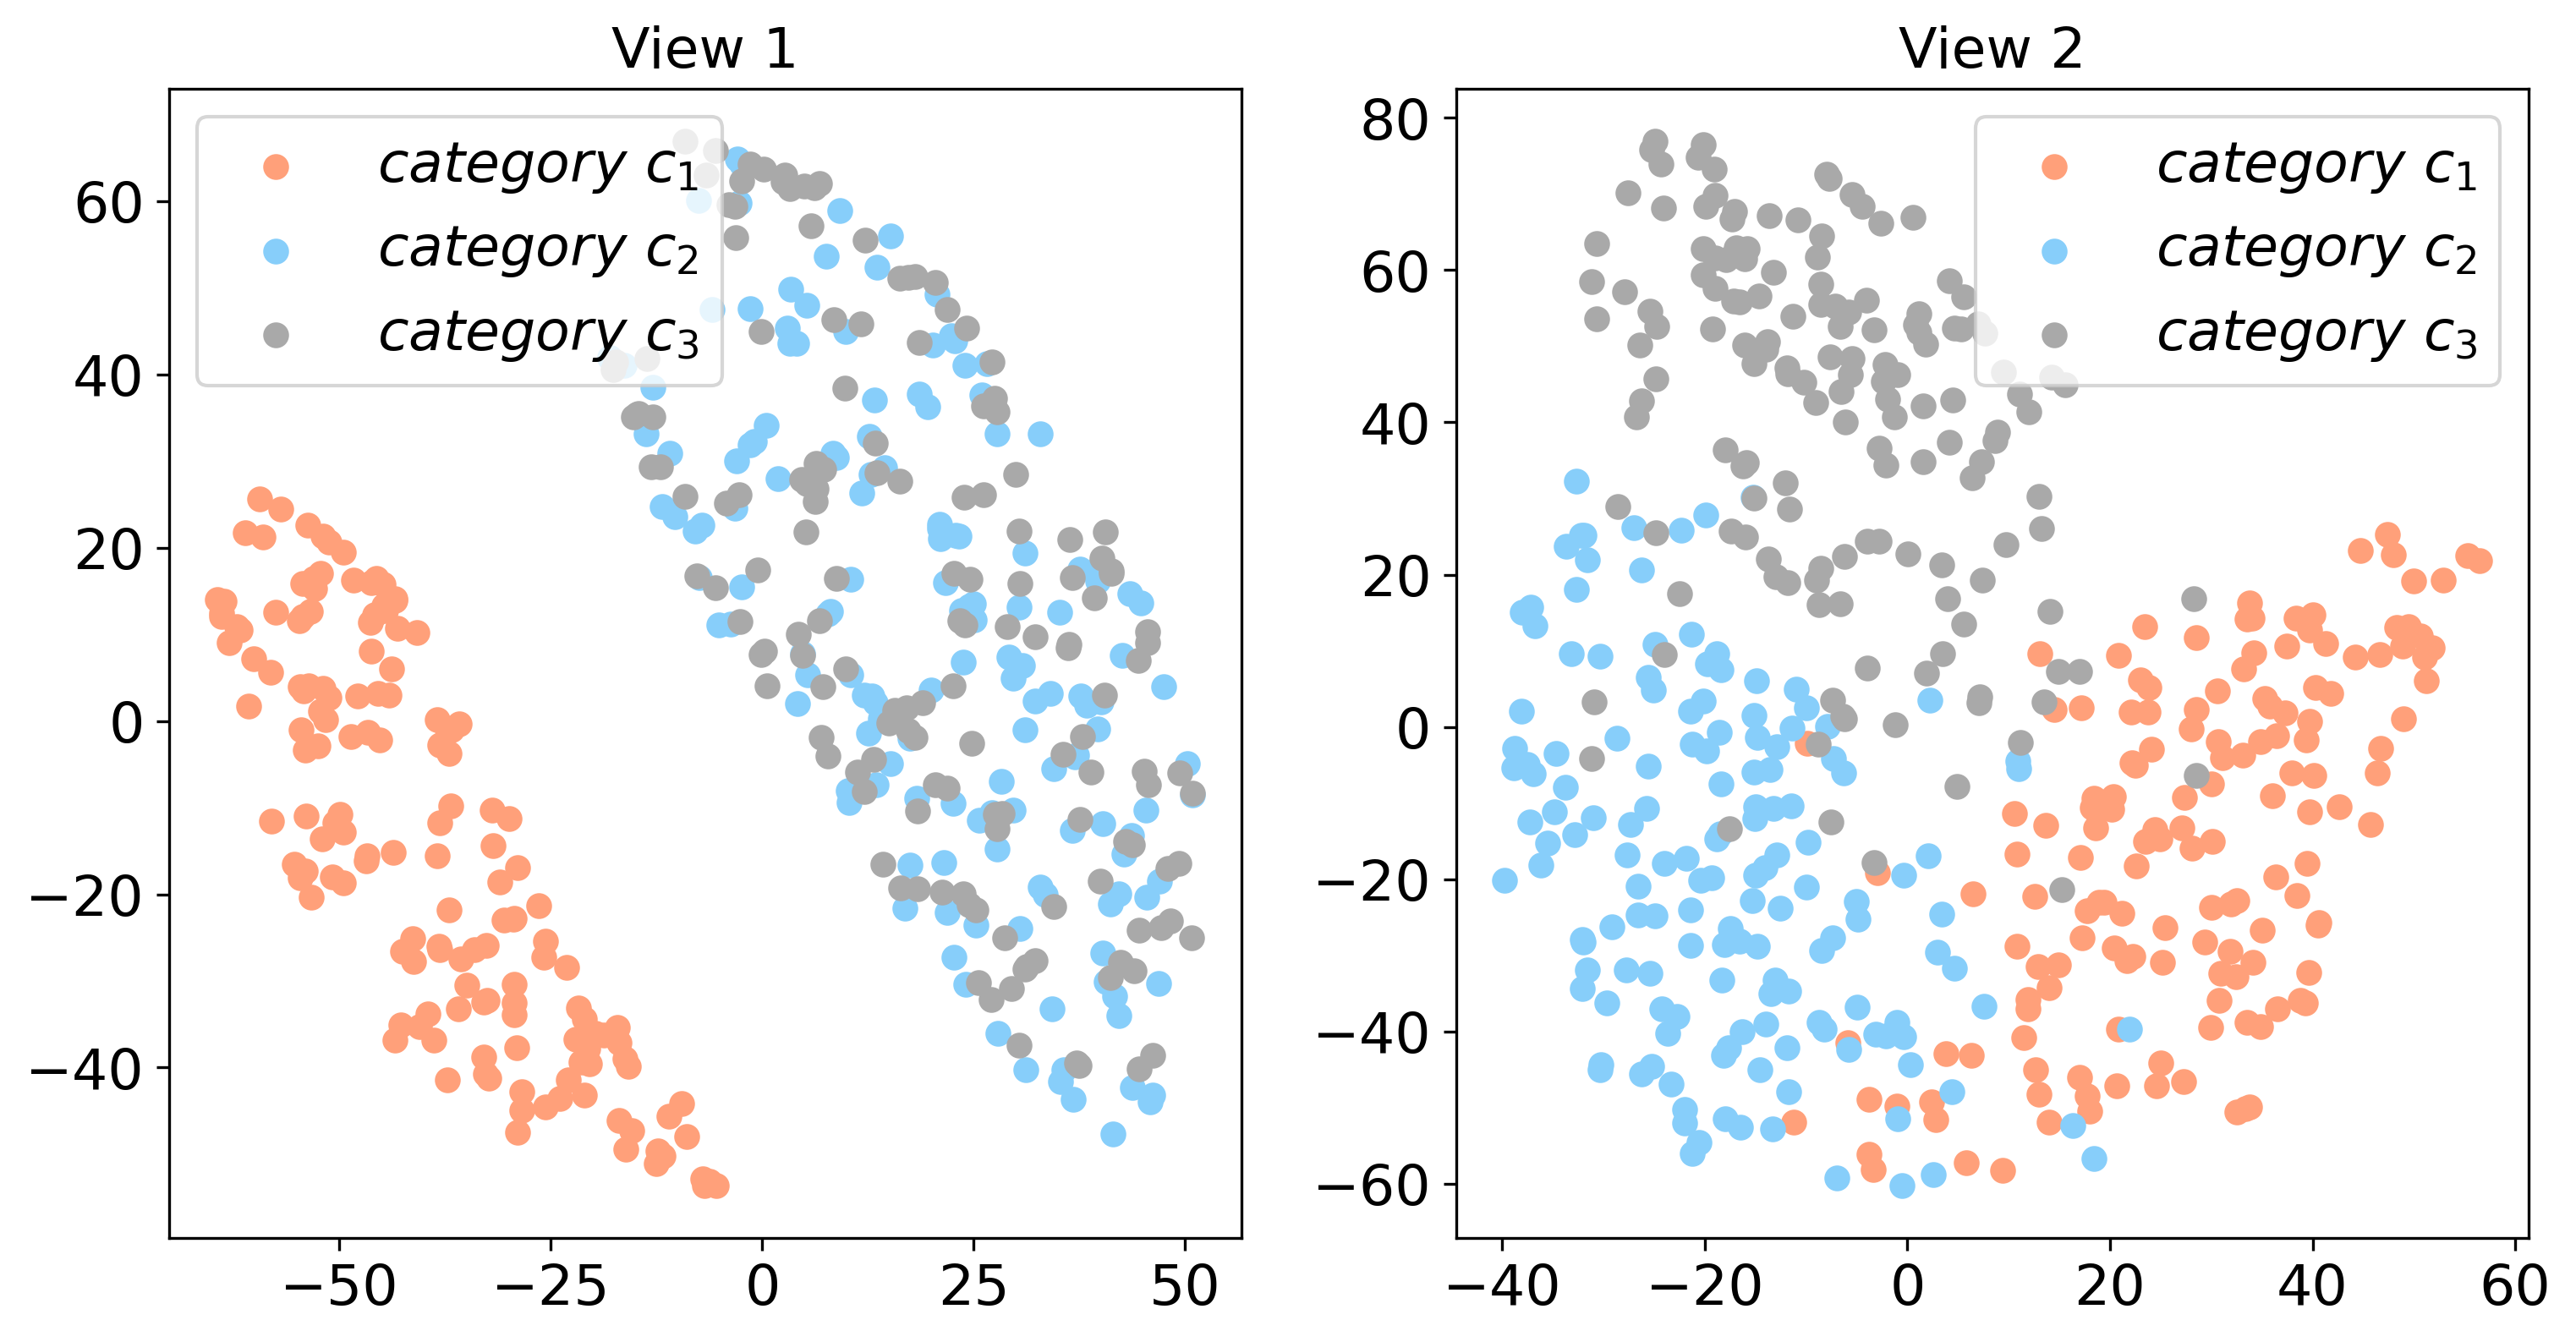

In [6]:
import matplotlib
from matplotlib import pyplot as plt

# Add font family "Microsoft YaHei" to support Chinese.
# matplotlib.rcParams['font.family'].insert(0, 'Microsoft YaHei')
matplotlib.rcParams.update(dict(
    zip(['legend.fontsize',
         'axes.labelsize',
         'axes.titlesize',
         'xtick.labelsize',
         'ytick.labelsize'],
        [16] * 5)
))

candi_color = ["lightsalmon", "lightskyblue", "darkgray", "black", "blue", "red"]

plt.figure(figsize=(12, 6), dpi=300)
for vi in range(2):
    plt.subplot(121 + vi)
    for i in range(3):
        x0 = features[vi][labels == i, 0].flatten()[:150]
        x1 = features[vi][labels == i, 1].flatten()[:150]
        plt.scatter(x0, x1, c=candi_color[i], s=40, label=r'$category\ c_%d$' % (i + 1))
    plt.title('View %d' % (vi + 1))
    plt.legend()


# plt.savefig('toy_visualization.eps', format='eps', bbox_inches='tight')
# plt.savefig('toy_visualization.jpg')
plt.show()
